In [1]:
import os
import re
import sys
import glob
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

In [96]:
cytb_aln = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/cytb_aln.fna", "fasta")]
nd1_aln  = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/nd1_aln.fna", "fasta")]

In [70]:
cytb_pos_distro = [defaultdict(int) for _ in range(len(cytb_aln[0]))]
for rec in cytb_aln:
    for pos, nuc in enumerate(rec.seq):
        cytb_pos_distro[pos][nuc] += 1


nd1_pos_distro = [defaultdict(int) for _ in range(len(nd1_aln[0]))]
for rec in nd1_aln:
    for pos, nuc in enumerate(rec.seq):
        nd1_pos_distro[pos][nuc] += 1

In [76]:
df_cytb = pd.DataFrame(cytb_pos_distro).fillna(0)
df_nd1 = pd.DataFrame(nd1_pos_distro).fillna(0)[df_cytb.columns]

In [72]:
df_cytb.describe()

-            !            A            T            G  \
count  1371.000000  1371.000000  1371.000000  1371.000000  1371.000000   
mean    221.673961     0.350839   330.325310   308.388767   142.015317   
std     492.506368     8.445110   480.057523   463.566858   367.938515   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000    49.000000     1.000000   
75%       0.000000     0.000000   660.500000   376.000000    47.000000   
max    1321.000000   223.000000  1322.000000  1322.000000  1322.000000   

                 C            R            N            Y  
count  1371.000000  1371.000000  1371.000000  1371.000000  
mean    319.196207     0.011670     0.025529     0.012400  
std     448.452520     0.107436     0.157782     0.110702  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%      16.000000     0.000000     0.000000     0.000000  
75%     585.000000     0.000000     0.000000     0.000000  
max    1322.000000     1.000000     1.000000     1.000000

In [77]:
df_nd1.describe()

-            !            A            T            G  \
count  1008.000000  1008.000000  1008.000000  1008.000000  1008.000000   
mean     66.880952     1.490079   391.375992   355.398810   147.825397   
std     289.396066    33.938432   495.413691   475.910304   369.487166   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000    40.500000   140.000000     4.000000   
75%       0.000000     0.000000   823.500000   481.250000    59.000000   
max    1323.000000   984.000000  1324.000000  1324.000000  1324.000000   

                 C           R            N           Y  
count  1008.000000  1008.00000  1008.000000  1008.00000  
mean    360.927579     0.00496     0.091270     0.00496  
std     459.460936     0.07029     0.301606     0.07029  
min       0.000000     0.00000     0.000000     0.00000  
25%       0.000000     0.00000     0.000000     0.00000  
50%      94.500000     0.00000     0.000000     0.00000  
75%     636.750000     0.00000     0.000000     0.00000  
max    1324.000000     1.00000     2.000000     1.00000

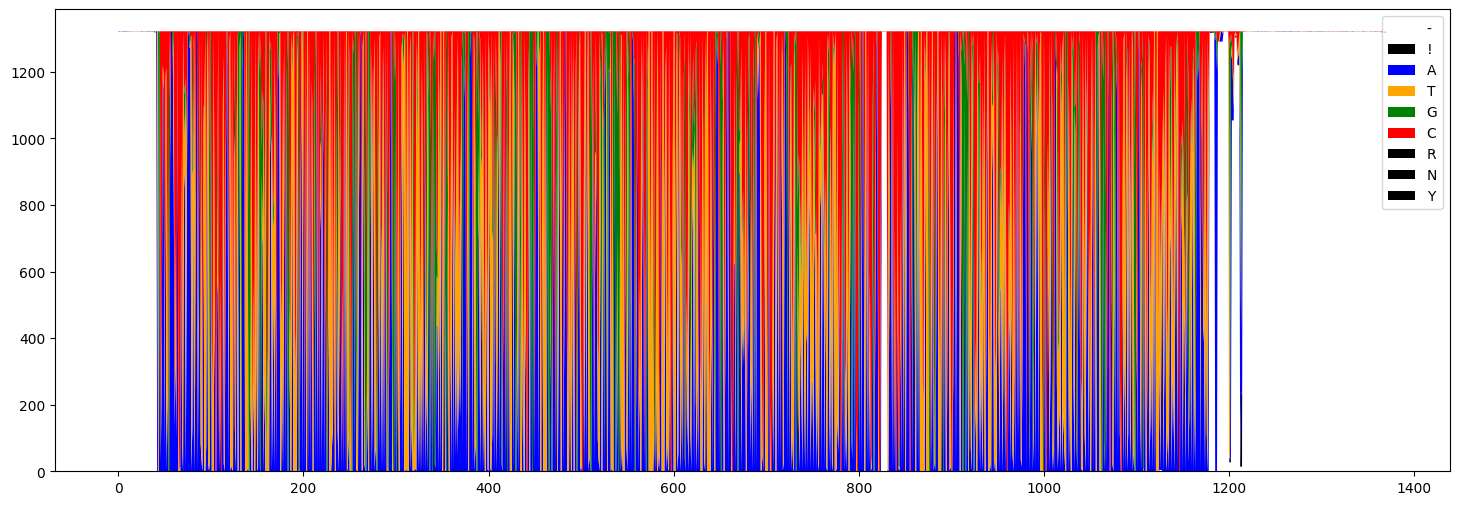

In [59]:
plt.figure(figsize=(18, 6))
plt.stackplot(df_cytb.index.values, [df_cytb[x].values for x in df_cytb.columns], labels=df_cytb.columns, colors=["w", "k", "b", "orange", "g", "r", "k", "k", "k"])
plt.legend();

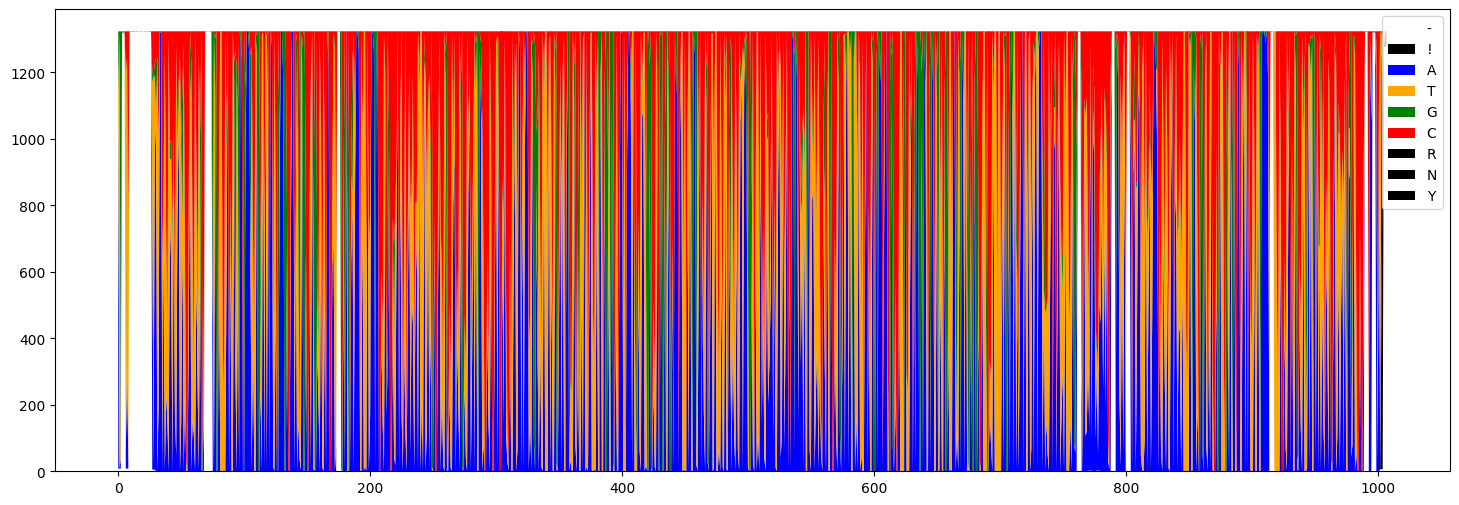

In [78]:
plt.figure(figsize=(18, 6))
plt.stackplot(df_nd1.index.values, [df_nd1[x].values for x in df_nd1.columns], labels=df_nd1.columns, colors=["w", "k", "b", "orange", "g", "r", "k", "k", "k"])
plt.legend();

In [79]:
df_cytb["Nuc"] = df_cytb[["A", "C", "G", "T"]].sum(axis=1)
df_cytb["NonNuc"] = df_cytb.drop(["A", "C", "G", "T", "Nuc"], axis=1).sum(axis=1)

df_nd1["Nuc"] = df_nd1[["A", "C", "G", "T"]].sum(axis=1)
df_nd1["NonNuc"] = df_nd1.drop(["A", "C", "G", "T", "Nuc"], axis=1).sum(axis=1)

In [81]:
(df_cytb.NonNuc == 0).value_counts()

True     1041
False     330
Name: NonNuc, dtype: int64

In [82]:
(df_nd1.NonNuc == 0).value_counts()

True     830
False    178
Name: NonNuc, dtype: int64

## Clean up headers

In [115]:
cytb_aln = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/cytb_aln.fna", "fasta")]
nd1_aln  = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/nd1_aln.fna", "fasta")]

In [116]:
sp_map = dict()
sp_map_rev = dict()
i = 1
for rec in cytb_aln:
    tmp = "RN_{}".format(i)
    header = rec.description
    if header == "Cociella_crocodila":
        idx = "OUTGRP"
    else:
        idx = sp_map_rev.get(header, tmp)
    
    sp_map[idx] = header
    sp_map_rev[header] = idx

    rec.id = idx
    rec.name = idx
    rec.description = idx
    i += 1

for rec in nd1_aln:
    tmp = "RN_{}".format(i)
    header = rec.description
    if header == "Cociella_crocodila":
        idx = "OUTGRP"
    else:
        idx = sp_map_rev.get(header, tmp)
    
    sp_map[idx] = header
    sp_map_rev[header] = idx

    rec.id = idx
    rec.name = idx
    rec.description = idx
    i += 1

In [117]:
len(sp_map), len(sp_map_rev), len(nd1_aln), len(cytb_aln)

(1324, 1324, 1324, 1322)

In [118]:
assert sp_map == {x:y for y,x in sp_map_rev.items()}
pd.Series(sp_map).to_csv("../data/exposure/mammals/names_map.txt", sep="\t", header=False)

SeqIO.write(nd1_aln, "../data/exposure/mammals/mulal/nd1_aln_coded.fna", "fasta-2line")
SeqIO.write(cytb_aln, "../data/exposure/mammals/mulal/cytb_aln_coded.fna", "fasta-2line")

1322